<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4 (Group 5) - Multi-Classification of Stroke, Mild Stroke and No Stroke

> Authors: Suen Si Min, Lee Hongwei, Irfan Muzafar (Group 5)
---

**Problem Statement:**  
How might we help patients confidently assess if they experienced a mild stroke, using a precise and sensitive classification model?

---
There are a total of four notebooks for this project:  
 1. `01_Data_Cleaning_EDA.ipynb`   
 2. `02_Modelling_Evaluation.ipynb`   
 3. `03_Clustering_Reclassification.ipynb`
 4. `04_Cluster_Exploration_Conclusion.ipynb`

---
**This Notebook**
- Fit our data into various classification models and evaluate the performance of each model. 
- Hypertune, re-evaluate and select our preferred model.
- Identify people who actually succumbed to stroke and people who actually did not succumb to stroke, with the hypothesis that the wrongly classified people might have previously gotten a Transcient Ischemic Attack (TIA).

---

# Part 1 - Supervised Classification Models

<h2>1. Import libraries</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [2]:
# Set a random seed
np.random.seed(42)

---

<h2>2. Import Cleaned Data from CSV</h2>

In [3]:
# Import CSV and assign it as df
df = pd.read_csv('../datasets/cleaned_data.csv')

In [4]:
# Check info of dataframe to ensure correct file is imported
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20458 entries, 0 to 20457
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   diabetes_012          20458 non-null  int64
 1   highbp                20458 non-null  int64
 2   highchol              20458 non-null  int64
 3   bmi                   20458 non-null  int64
 4   smoker                20458 non-null  int64
 5   stroke                20458 non-null  int64
 6   heartdiseaseorattack  20458 non-null  int64
 7   physactivity          20458 non-null  int64
 8   fruits                20458 non-null  int64
 9   veggies               20458 non-null  int64
 10  hvyalcoholconsump     20458 non-null  int64
 11  anyhealthcare         20458 non-null  int64
 12  nodocbccost           20458 non-null  int64
 13  genhlth               20458 non-null  int64
 14  menthlth              20458 non-null  int64
 15  physhlth              20458 non-null  int64
 16  diff

> <br>
> <strong>Our Choice of Models:</strong><br> 
> <br>

We have chosen 6 Classification Models:
|       | **Classifier Model**            | **Description**                                                                                                                                                                                                         |
|-------|---------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1** | Decision Tree Classifier  | Starts with a root node, the question in each column gets asked at every node to classify the data points into two groups. The process repeats.                                                                         |
| **2** | Random Forest Classifier  | An ensemble learning method that combines the output of multiple decision trees. <br>The random forest would count the number of predictions from decision trees and choose the most popular prediction.                |
| **3** | Bagging Classifier        | (Bootstrap Aggregating) Bootstrapping rows of our train dataset and aggregating to get the ensemble model                                                                                                               |
| **4** | Adaboost Classifier       | Wrong predictions will increase in probability of being picked in the next train set so that it trains the model better                                                                                                 |
| **5** | Support Vector Classifier | Finds an optimal hyperplane that maximises margins between two classes of datapoints                                                                                                                                    |
| **6** | Gradient Boost Classifier | Uses boosting to make predictive models from an ensemble of weak predictive learners. <br>Calculating Residuals (difference between actual classification and predicted probability) and using it to get the next tree. |

Using a pipeline, we will scale our data using `StandardScaler` before fitting each model

---

<h2>3. Base Modelling</h2>

<h3>3.1 Determine X & y</h3>

In [5]:
# Assign X & y variables
X = df.drop(columns=['stroke'])
y = df['stroke']

In [6]:
# Check that target variable is balanced
y.value_counts(normalize=True) 

stroke
1    0.5
0    0.5
Name: proportion, dtype: float64

<h3>3.2 Train-Test-Split</h3>

In [7]:
# Perform Train-Test-Split on X & y, with 25% of the data split into the test set and 75% split into train set. Stratify y to ensure that the training and test datasets have the same proportion of class labels as the input dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, stratify=y)

In [8]:
# Check that target variable in train and test set is balanced
y_train.value_counts(normalize=True) 

stroke
1    0.500033
0    0.499967
Name: proportion, dtype: float64

<h3>3.3 Run Models</h3>

In [9]:
# Set a random seed
np.random.seed(42)

# Initialize the models - store them in a models dictionary
models = {
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Adaboost Classifier': AdaBoostClassifier(),
    'Support Vector Classifier': SVC(),
    'Gradient Boost Classifier': GradientBoostingClassifier()
}

# Train and evaluate each model's scores - store them in a scores dictionary
scores = {'Model': [], 'Train CV F1': [], 'Test CV F1': []}

for name, model in models.items():
    # Create a pipeline with StandardScaler and the model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Calculate 5 fold cross validation train score, specifying on F1 Score
    train_cross_val_f1 = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'f1').mean()

    # Calculate 5 fold cross validation test score, specifying on F1 Score
    test_cross_val_f1 = cross_val_score(model, X_test, y_test, cv = 5, scoring = 'f1').mean()

    # Make predictions on training & test dataset
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Append scores to the scores dictionary
    scores['Model'].append(name)
    scores['Train CV F1'].append(train_cross_val_f1)
    scores['Test CV F1'].append(test_cross_val_f1)

# Create a DataFrame from the scores dictionary
base_classification_df = pd.DataFrame(scores)

In [10]:
# View base scores dataframe
base_classification_df

,Model,Train CV F1,Test CV F1
0,Decision Tree Classifier,0.656425,0.662507
1,Random Forest Classifier,0.753842,0.760998
2,Bagging Classifier,0.705192,0.703561
3,Adaboost Classifier,0.748190,0.754440
4,Support Vector Classifier,0.755588,0.765905
5,Gradient Boost Classifier,0.761466,0.767612


> <br>
> <strong>Interpretation cum Choice of Models to Proceed for Hyperparameter Tuning:</strong><br> 
> <br>


We have chosen 3 Classification Models to proceed with hyperparameter tuning so as to optimise each of the model's performance:
|       | **Classifier Model**            | **Rationale**                                                                                                                                                                                         |
|-------|---------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **1** | Random Forest Classifier  | - In general, tree-based models tend to overfit. <br>- However, comparing Decision Tree, Random Forest & Bagging Classifiers, the 5-fold F1 score for Random Forest Classifer did not overfit.<br>- Its scores are also rather similar/comparable to the non tree-based models.|
| **2** | Support Vector Classifier | - Train & Test CV F1 scores are high and trained model is generalisable to the test dataset|
| **3** | Gradient Boost Classifier | - Train & Test CV F1 scores are high and trained model is generalisable to the test dataset|

---

<h2>4. Hyperparameter Tuning of Chosen Models</h2>

<p>Optimizing Model Performance through Hyperparameter Tuning</p>

<h3>4.1 Hyperparameter Tuning Using Grid Search: Support Vector Classifier (SVC)</h3>

<h4>4.1.1 Getting the Best Hyperparameters</h4>

In [11]:
# Define the hyperparameter grid
param_grid_svc = {
    'svc__C': [0.1, 1],                         # Regularization parameter
    'svc__kernel': ['linear', 'poly', 'rbf'],   # Kernel type: linear or radial basis function (RBF)
    'svc__gamma': ['scale', 'auto'],            # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
    'svc__degree': [2, 3, 4],                   # Degree of the polynomial kernel (if kernel='poly')
}

# Create a pipeline with StandardScaler and SVC
pipe_svc = Pipeline([
    ('scaler', StandardScaler()),  # StandardScaler for feature scaling
    ('svc', SVC())
])

# Initialize GridSearchCV with the pipeline and hyperparameter grid
svc_gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid_svc, cv=5, scoring='f1', verbose=2)

# Fit the GridSearchCV to the training data; Do not use on full dataset because we want a portion of unseen data to be used to test the model
svc_gs.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Hyperparameters:", svc_gs.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=linear; total time=   2.1s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=linear; total time=   2.1s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=linear; total time=   2.0s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=linear; total time=   2.0s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=linear; total time=   2.1s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=poly; total time=   2.3s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=poly; total time=   2.3s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=poly; total time=   2.4s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=poly; total time=   2.3s
[CV] END svc__C=0.1, svc__degree=2, svc__gamma=scale, svc__kernel=poly; total time=   2.3s
[CV] END svc__C=0.

<h4>4.1.2 Use Best Hyperparameters on Model to Make Predictions</h4>

In [12]:
# Evaluate the best model on the X_train & X_test to get predictions
y_train_pred_svc = svc_gs.predict(X_train)
y_test_pred_svc = svc_gs.predict(X_test)

# Calculate F1 score on the train & test dataset
print(f'F1-score for train dataset on SVC: {f1_score(y_train, y_train_pred_svc)}')
print(f'F1-score for test dataset on SVC: {f1_score(y_test, y_test_pred_svc)}')

F1-score for train dataset on SVC: 0.7643627140139504
F1-score for test dataset on SVC: 0.7641847313854853


<h3>4.2 Hyperparameter Tuning Using Grid Search: Gradient Boost</h3>

<h4>4.2.1 Getting the Best Hyperparameters</h4>

In [13]:
# define hyperparameter grid
gboost_params = {
    'gb__max_depth': [2,3,4],
    'gb__n_estimators': [75, 100, 125],
    'gb__learning_rate': [.06 , .08, .1]
}

# create pipeline with standardscaler and gradient boost
pipe_gb = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])

# initialize gridsearchcv
gb_gs = GridSearchCV(estimator=pipe_gb, param_grid=gboost_params, cv=5, scoring='f1', verbose=1)

# fit gridsearchcv to training data
gb_gs.fit(X_train, y_train)

# find best parameters
print('Best Hyperparameters:', gb_gs.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'gb__learning_rate': 0.06, 'gb__max_depth': 3, 'gb__n_estimators': 100}


<h4>4.2.2 Use Best Hyperparameters on Model to Make Predictions</h4>

In [14]:
# Evaluate the best model on the X_train & X_test to get predictions
y_train_pred_gb = gb_gs.predict(X_train)
y_test_pred_gb = gb_gs.predict(X_test)

# Calculate F1 score on the train & test dataset
print(f'F1-score for train dataset on gradient boost: {f1_score(y_train, y_train_pred_gb)}')
print(f'F1-score for test dataset on gradient boost: {f1_score(y_test, y_test_pred_gb)}')

F1-score for train dataset on gradient boost: 0.7668118961924607
F1-score for test dataset on gradient boost: 0.7689992475545523


<h3>4.3 Hyperparameter Tuning Using Grid Search: Random Forest</h3>

<h4>4.3.1 Getting the Best Hyperparameters</h4>

In [15]:
# Ran hyperparameter tuning on another computer to find best parameters as below

# define hyperparameter grid
rforest_params = {
    'rf__ccp_alpha': [0.001],
    'rf__max_depth': [None],
    'rf__n_estimators': [200]
}

# create pipeline with standardscaler and gradient boost
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

# initialize gridsearchcv
rf_gs = GridSearchCV(estimator=pipe_rf, param_grid=rforest_params, cv=5, scoring='f1', verbose=1)

# fit gridsearchcv to training data
rf_gs.fit(X_train, y_train)

# find best parameters
print('Best Hyperparameters:', rf_gs.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'rf__ccp_alpha': 0.001, 'rf__max_depth': None, 'rf__n_estimators': 200}


<h4>4.3.2 Use Best Hyperparameters on Model to Make Predictions</h4>

In [16]:
# Evaluate the best model on the X_train & X_test to get predictions
y_train_pred_rf = rf_gs.predict(X_train)
y_test_pred_rf = rf_gs.predict(X_test)

# Calculate F1 score on the train & test dataset
print(f'F1-score for train dataset on random forest: {f1_score(y_train, y_train_pred_rf)}')
print(f'F1-score for test dataset on random forest: {f1_score(y_test, y_test_pred_rf)}')

F1-score for train dataset on random forest: 0.7635695737538791
F1-score for test dataset on random forest: 0.7698948948948948


<h3>4.4 Selected Model</h3>

<h4>4.4.1 Summary of Scores</h4>

**<span style="color:blue">Before Hypertuning</span> (Baseline Models)**
|   | **Classifier Model**      | **Train CV F1** | **Test CV F1** |
|---|---------------------------|--------------|-------------|
| 1 | Random Forest Classifier| 0.753842    | 0.760998    |
| 2 | Support Vector Classifier| 0.755588     | 0.765905    |
| 3 | Gradient Boost Classifier| 0.761466    | 0.767612    |

<br>

**<span style="color:blue">After Hypertuning</span>**
|   | **Classifier Model**              | **Train CV F1** | **Test CV F1** |
|---|-----------------------------------|--------------|-------------|
| 1 | Random Forest Classifier (Tuned)  | 0.763569| 0.769894|
| 2 | Support Vector Classifier (Tuned) | 0.764362| 0.764184|
| 3 | Gradient Boost Classifier (Tuned) | 0.766811| 0.768999|

> <br>
> <strong>Interpretation of Table of Scores:</strong><br> 
> <br>

- Of the 3 models hypertuned, Random Forest has had the largest improvement across Train and Test datasets and the highest Test F1 score validated with 5 folds. 
- In comparison, the F1 scores for the Train and Test set that went through Gradient Boost Classification has a high and balanced F1 score across the splits. 
- To verify the best model, we want to compare the best F1 score on the full dataset as that will be the next step in our classification (refer to [here for explanation](#explanation-for-obtaining-f1-score-on-full-dataset))

<h4>4.4.2 Calculate F1 Score on Full Dataset</h4>

In [17]:
# Calculate F1 score on full dataset

print(f'F1-score for full dataset on random forest: {f1_score(y, rf_gs.predict(X))}')
print(f'F1-score for full dataset on gradient boost: {f1_score(y, gb_gs.predict(X))}')

F1-score for full dataset on random forest: 0.7651655064639865
F1-score for full dataset on gradient boost: 0.7673616035550512


##### **Explanation for Obtaining F1 score On Full Dataset**

- We want to ensure all data in both train and test sets are accounted for in our prediction and in our F1 score, because for all the data which were wrongly classified, we want to reclassify them in the later part of our analysis.
- Hence, with our best model, we want to now predict the labels across the full dataset.

> <br>
> <strong>Selected Model:</strong><br> 
> <br>

- We will proceed to use the tuned Gradient Boost Classifier model as it has a higher F1 score for full dataset compared to Random Forest.

<h4>4.4.3 Confusion Matrix</h4>

##### **Explanation for Running Confusion Matrix On Full Dataset**<br>

- Refer to [Explanation for Obtaining F1 score On Full Dataset](#explanation-for-obtaining-f1-score-on-full-dataset)

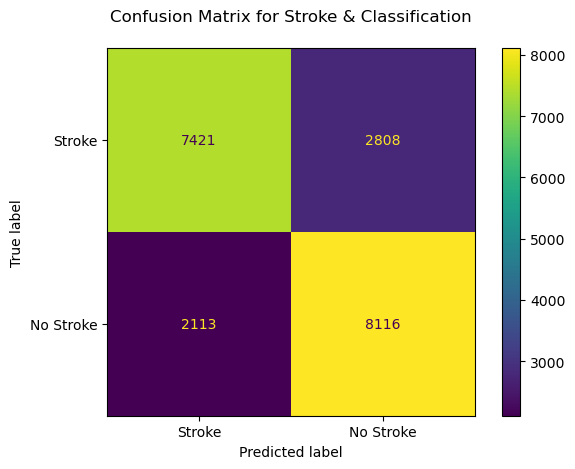

In [18]:
# Obtain true and predicted target values from full dataset
tn, fp, fn, tp = confusion_matrix(y, gb_gs.predict(X)).ravel()

# Define custom matrix so true positive is top left and true negative is bottom right
custom_cm = np.array([[tp, fn],
                      [fp, tn]])

# Create custom labels
custom_display_labels = ['Stroke', 'No Stroke']

# Plot confusion matrix with the custom layout
cm_gb = confusion_matrix(y, gb_gs.predict(X))
disp =ConfusionMatrixDisplay(confusion_matrix=cm_gb,
                             display_labels=custom_display_labels)

disp.plot()

# Set the title
plt.title("Confusion Matrix for Stroke & Classification", y = 1.05)
plt.tight_layout()
plt.show()

**Observations & Interpretations of Confusion Matrix:**

- **True Positives: 7421 data points**<br>
    - Refers to persons who actually have had a stroke and were predicted by the model to have had stroke

- **False Negatives: 2808 data points**<br>
    - Refers to persons who actually have had a stroke and were predicted by the model to NOT have had stroke

- **False Positives: 2113 data points**<br>
    - Refers to persons who actually DID NOT have stroke and were predicted by the model to have had stroke

- **True Negatives: 8116 data points**<br>
    - Refers to persons who actually DID NOT have a stroke and were predicted by the model to NOT have had stroke

---

# Part 2 - Prepare for Unsupervised Classification Models

Our next step is to employ unsupervised classification modelling to our wrongly classified data (i.e. False Negatives and False Positives). 
<br>The context and rationales are detailed as follows:

**Context:**<br>
In the case of **mild stroke** or its scientific term **'Transcient Ischemic Attack (TIA)'**, we hypothesise that surveyees who have experienced TIA are very likely to be in the wrongly classified data set (see below for detailed explanation):

**False Negatives:** 
1. Might apply to persons who actually experienced a full stroke but our model classified as no stroke 
    - **Interpretation:** This suggests that their attributes are more alike those who actually never experienced a stroke
2. Or might apply to persons who actually experienced a TIA but our model classified as no stroke
    - **Interpretation:** Since the original survey questions did not distinguish between TIA and a full stroke, they could have answered 'yes' to stroke but experienced a TIA

**False Positives:**
1. Might apply to persons who  actually never experienced a stroke but our model classified them as having had stroke before
    - **Interpretation:** This suggests that their attributes are more alike those who have experienced a stroke.
2. Or might apply to persons who actually never experienced a full stroke but experienced a TIA
    - **Interpretation:** As above, they might have answered 'no' to stroke as they did not perceive their TIA as a stroke.

**Conclusion:**<br>
- Based on the above, we hypothesise that our wrongly classified data contains **3 clusters**: Stroke, No stroke, and Mild Stroke. 
- We will proceed to test our hypothesis in the next notebook via **unsupervised classification algorithms** to create the 3 new classifications.

**Next Step:**<br>
We will extract the wrongly classified data into a new dataframe to perform the unsupervised classification which will be covered in the next notebook.

<h2>1. Prepare Data for Unsupervised Classification</h2>

<h3>1.1 Add Predicted Labels to Existing Dataframe</h3>

In [19]:
# Add a new column containing the predicted labels
df['pred_stroke'] = gb_gs.predict(X)

In [20]:
# Check Output
df.head()

,diabetes_012,highbp,highchol,bmi,smoker,stroke,heartdiseaseorattack,physactivity,fruits,veggies,...,nodocbccost,genhlth,menthlth,physhlth,diffwalk,sex,age,education,income,pred_stroke
0,0,0,1,33,1,1,0,1,0,1,...,1,4,30,28,0,0,4,6,2,0
1,0,1,1,22,0,1,1,0,1,0,...,0,3,30,0,1,0,12,4,4,1
2,2,1,1,37,1,1,1,0,0,1,...,0,5,0,0,1,1,10,6,5,1
3,2,1,1,34,1,1,0,1,0,0,...,0,4,0,7,1,0,9,5,4,1
4,0,0,0,28,1,1,0,0,1,1,...,1,4,15,30,1,0,7,4,3,1


<h3>1.2 Dataframe of Wrongly Classified Data</h3>

In [21]:
# Create a dataframe of data which were wrongly classified
wrong_class_labeled = df[df['stroke']!=df['pred_stroke']]

In [22]:
# Check Output
wrong_class_labeled.shape

(4921, 22)

In [23]:
# Export this dataframe into a CSV
wrong_class_labeled.to_csv('../datasets/wrongly_classified_labeled.csv', index=False)

<h3>1.3 Dataframe of Wrongly Classified Data Without Labels</h3>

In [24]:
# Create a dataframe of data which were wrongly classified, without the label columns
wrong_class = wrong_class_labeled.drop(columns=['stroke', 'pred_stroke'])

In [25]:
# Check Output
wrong_class.shape

(4921, 20)

In [26]:
# Export this dataframe into a CSV
wrong_class.to_csv('../datasets/wrongly_classified.csv', index = False)

---

# Part 3 - Conclusion for This Notebook

**Summary of Actions**

- We began by performing 6 **supervised classification baseline models**, on our data. 

- After which, we selected the best 3 of 6 of these models to undergo **hyperparameter tuning** to optimize their performances.

- We then selected the best performing model based on F1 score to **make predictions** on our data.

- From the predictions, we extracted the False Positives and False Negatives to undergo **unsupervised classification** to create 3 new classifications, Stroke, No stroke, and Mild Stroke, which will be covered in the next notebook.

- Preparation of the unsupervised classification was done before **exporting the file.**